## Introducción:
En el siguiente proyecto se trabajará con un problema habitual en el mundo bancario; la otorgación de préstamos a clientes según su comportamiento financiero e historial de pagos. El objetivo de este proyecto es crear un modelo que prediga si una persona cumplirá con los pagos de un posible préstamo, y para para ello se contará con un dataset que comprende la información de 12500 clientes del banco. Dentro de las caracteristicas que se tienen para cada uno de los registros se tienen: edad del historial crediticio, tasa de interes actual para cada cliente, tiempo de atraso en el pago de las cuotas, cantidad de tarjetas de crédito , ingreso anual , entre otras características de interés.

Para la elección de las métricas de evaluación se decidió trabajar con **recall** , **precision** y **F1-Score** , precision porque en este problema se cuenta con un dataset desbalanceado y además es muy importante acertar en la mayor cantidad de los casos cuando un cliente NO pagará un préstamo para minimizar las pérdidas del banco (Recall). Por otro lado, F1-Score reune una combinación de ambas métricas para obtener una evaluación combinada de ambas necesidades que tiene el banco.

In [ ]:
#librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import probplot

#Prep-procesamiento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split




In [ ]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    path = "/content/drive/My Drive"
except:
    print('Ignorando conexión drive-colab')

Mounted at /content/drive


# 2. Carga de datos y Análisis Exploratorio:

### Carga de Datos:

In [ ]:
pip install pyarrow

In [ ]:
df = pd.read_parquet('/content/drive/My Drive/dataset.pq', engine="pyarrow")

### Análisis Exploratorio:

In [ ]:
##Exploración Inicial dataframe 'df'
print("")
x,y = df.shape
print(f"El dataframe 'df' tiene {x} registros y {y} variables.")
print("")
print("Una muestra de los primeros 5 registros del dataframe 'df':")
display(df.head(5))


El dataframe 'df' tiene 12500 registros y 22 variables.

Una muestra de los primeros 5 registros del dataframe 'df':


,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0


In [ ]:
#tabla de columnas y sus respectivos tipo de datos:
dtype = df.dtypes.reset_index()
dtype.columns = ["Index", "dtype"]

#tabla de columnas y sus respectivos datos nulos:
null = pd.DataFrame(df.isna().sum()).reset_index()
null.columns = ["Index","null"]

#desripcion de variables categóricas:
categorical_desc = df.describe(exclude=np.number).T.reset_index()
categorical_desc.columns = ['Index', 'count', 'unique', 'top', 'freq']

#descripción de variables numéricas:
numerical_desc = df.describe(exclude=object).T.reset_index()
numerical_desc.columns = ['Index', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

#merge entre dtype y null:
dtype_null = dtype.merge(null, on = "Index")
#merge entre dtype_null y categorical_desc:
categorical_desc = categorical_desc.merge(dtype_null, on="Index", how="left")

#merge entre dtype_null y numerical_desc:
numerical_desc = numerical_desc.merge(dtype_null, on = "Index", how="left")

In [ ]:
print("Descripción de variables numéricas:")
print("")
numerical_desc

Descripción de variables numéricas:



,Index,count,mean,std,min,25%,50%,75%,max,dtype,null
0,age,12500.0,1.057718e+02,6.645027e+02,-5.000000e+02,25.000000,33.000000,42.000000,8.678000e+03,float64,0
1,annual_income,12500.0,1.616206e+05,1.297842e+06,7.005930e+03,19453.327500,37572.375000,72690.215000,2.383470e+07,float64,0
2,monthly_inhand_salary,10584.0,4.186635e+03,3.173690e+03,3.036454e+02,1622.408646,3087.595000,5967.937500,1.520463e+04,float64,1916
3,num_bank_accounts,12500.0,1.693992e+01,1.143508e+02,-1.000000e+00,3.000000,6.000000,7.000000,1.756000e+03,int64,0
4,num_credit_card,12500.0,2.317272e+01,1.320059e+02,0.000000e+00,4.000000,5.000000,7.000000,1.499000e+03,int64,0
5,interest_rate,12500.0,7.321336e+01,4.686822e+02,1.000000e+00,8.000000,14.000000,20.000000,5.789000e+03,int64,0
6,num_of_loan,12500.0,3.099440e+00,6.510528e+01,-1.000000e+02,1.000000,3.000000,5.000000,1.495000e+03,float64,0
7,delay_from_due_date,12500.0,2.106088e+01,1.486309e+01,-5.000000e+00,10.000000,18.000000,28.000000,6.700000e+01,int64,0
8,num_of_delayed_payment,11660.0,3.293542e+01,2.374377e+02,-3.000000e+00,9.000000,14.000000,18.000000,4.293000e+03,float64,840
9,changed_credit_limit,12246.0,1.039858e+01,6.799253e+00,-6.490000e+00,5.370000,9.410000,14.940000,3.697000e+01,float64,254


In [ ]:
print("Descripción de Variables Categóricas:")
print("")
categorical_desc

Descripción de Variables Categóricas:



,Index,count,unique,top,freq,dtype,null
0,customer_id,12500,12500,CUS_0xd40,1,object,0
1,occupation,12500,16,_______,880,object,0
2,payment_of_min_amount,12500,3,Yes,6571,object,0
3,payment_behaviour,12500,7,Low_spent_Small_value_payments,3202,object,0


In [ ]:
df.head()

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0


In [ ]:
#Gráfico de correlación de Pearson bi-variado.
df_temp = df.drop(columns=['customer_id']).copy()
px.imshow(df_temp.corr(), text_auto= '.2f',
                  width=950, height=950, zmin=-1, zmax=1, color_continuous_scale='BuPu')

<ipython-input-10-1d1233965a81>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  px.imshow(df_temp.corr(), text_auto= '.2f',


Skewness of age: 9.479069829804121
Kurtosis of age: 94.78018085134907


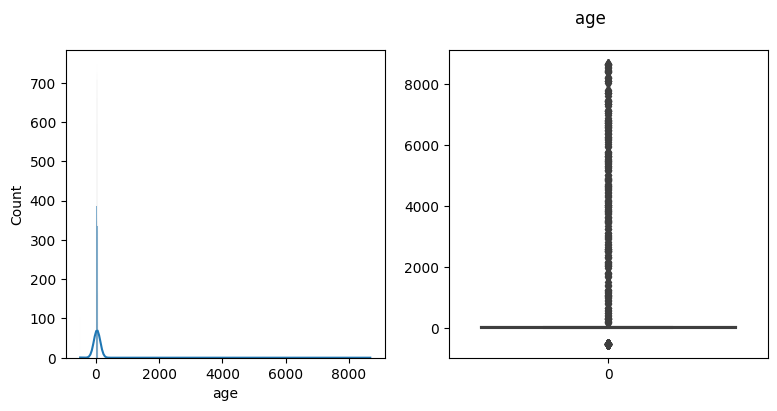

Skewness of annual_income: 12.757336609268155
Kurtosis of annual_income: 171.5565623134906


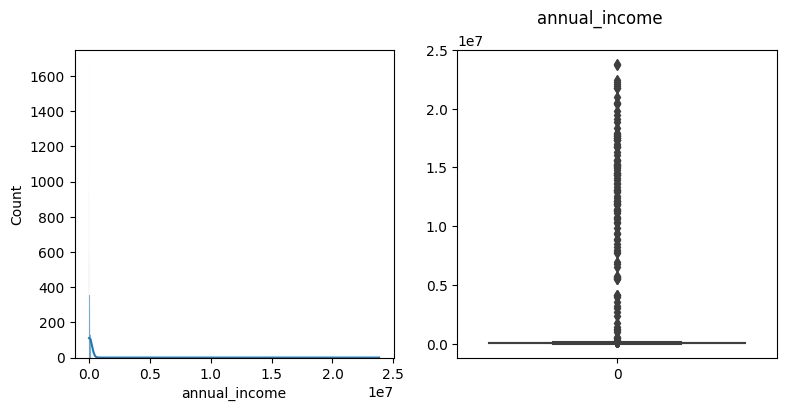

Skewness of monthly_inhand_salary: 1.1182934643384654
Kurtosis of monthly_inhand_salary: 0.5924024282832066


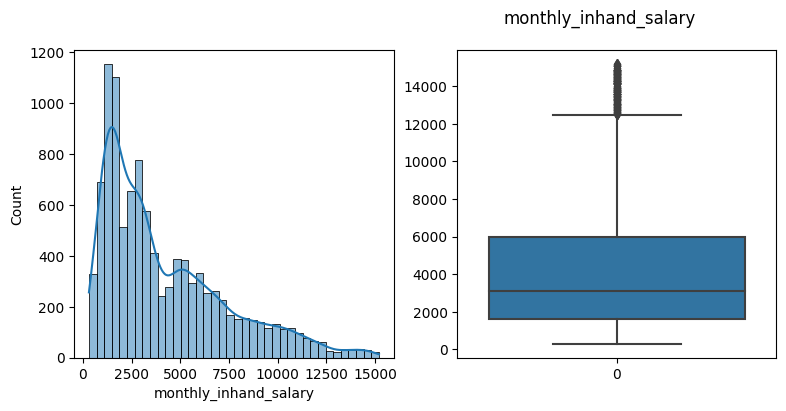

Skewness of num_bank_accounts: 11.10725607248947
Kurtosis of num_bank_accounts: 131.14426158868062


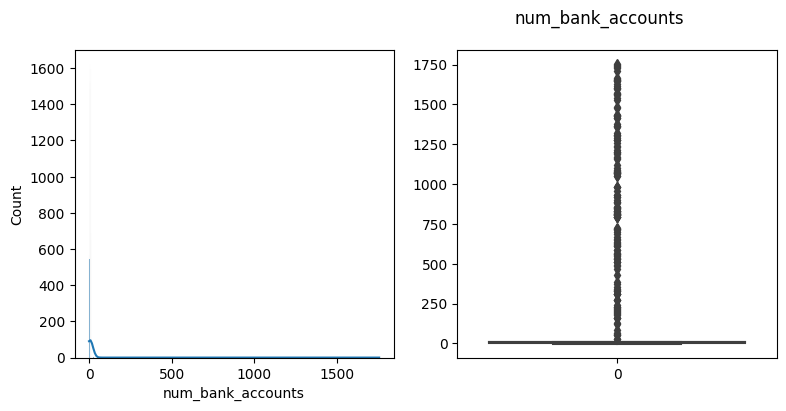

Skewness of num_credit_card: 8.309464304603086
Kurtosis of num_credit_card: 71.86427938883962


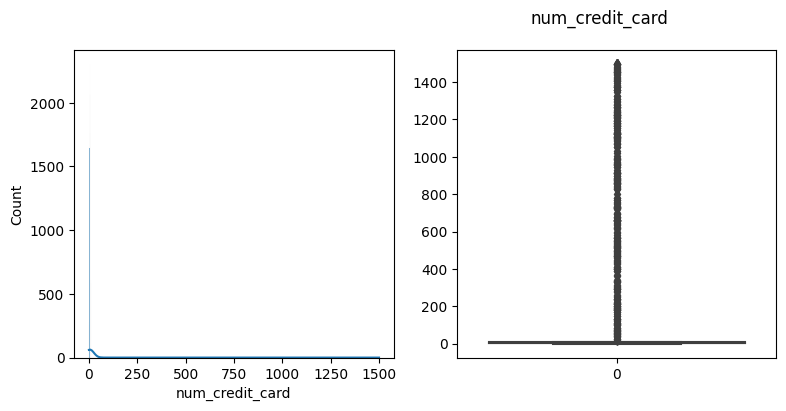

Skewness of interest_rate: 9.012670613693098
Kurtosis of interest_rate: 85.28318109573695


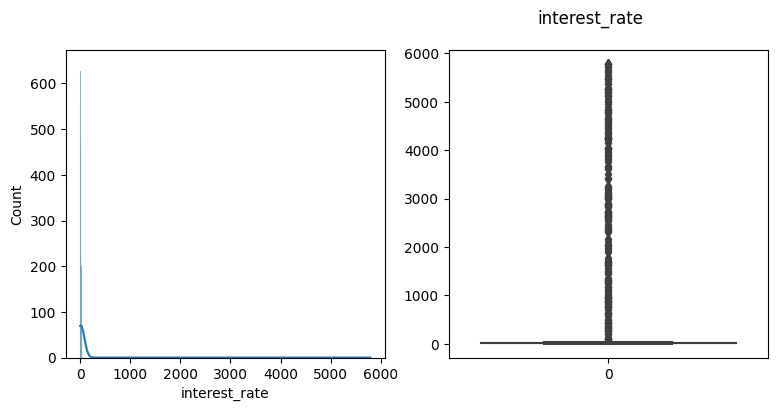

Skewness of num_of_loan: 15.84690971257845
Kurtosis of num_of_loan: 299.98358065214563


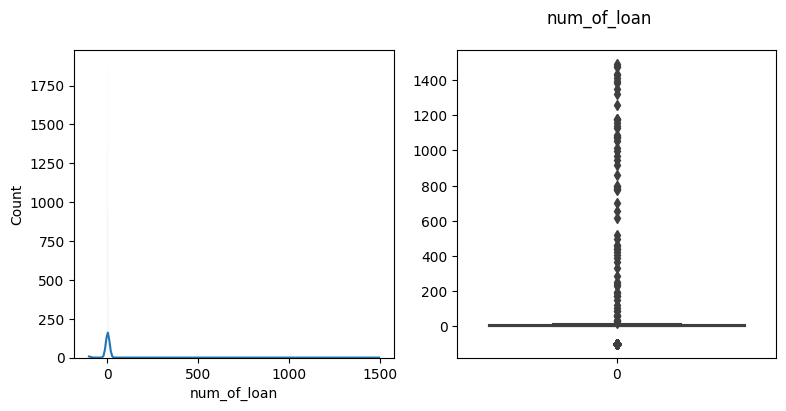

Skewness of delay_from_due_date: 0.9666666331644271
Kurtosis of delay_from_due_date: 0.35280490800210274


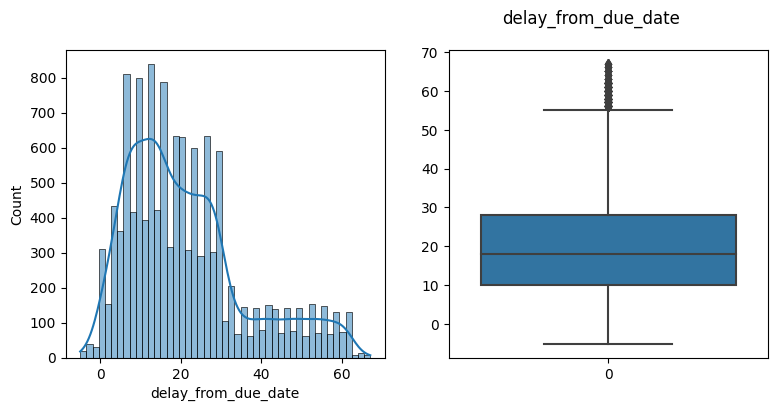

Skewness of num_of_delayed_payment: 13.27455763293581
Kurtosis of num_of_delayed_payment: 186.0352781846677


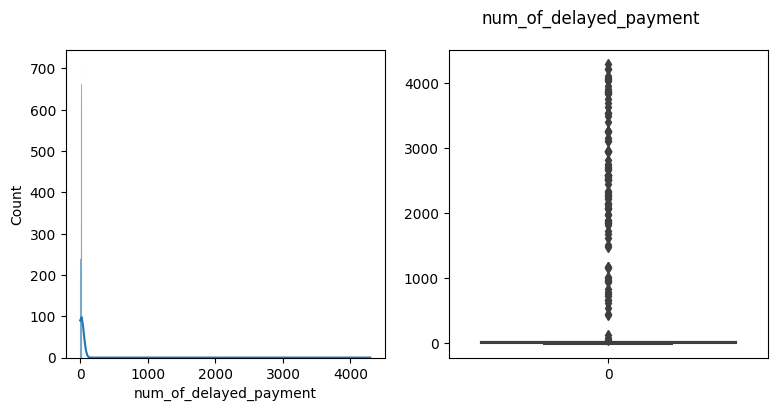

Skewness of changed_credit_limit: 0.6294883114219246
Kurtosis of changed_credit_limit: 0.09162528455434904


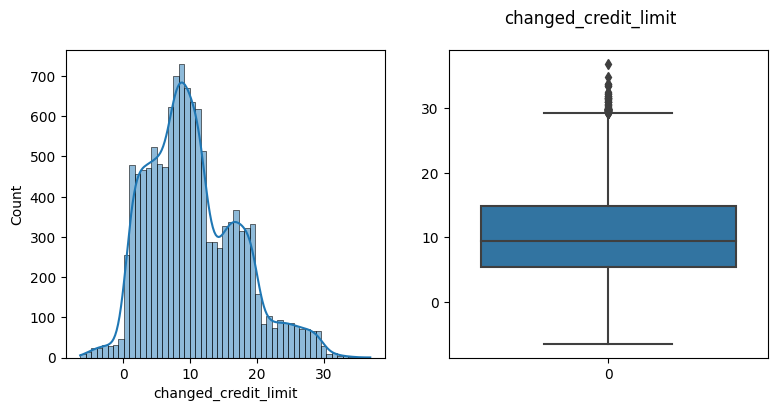

Skewness of num_credit_inquiries: 10.261076400185484
Kurtosis of num_credit_inquiries: 110.44086555760744


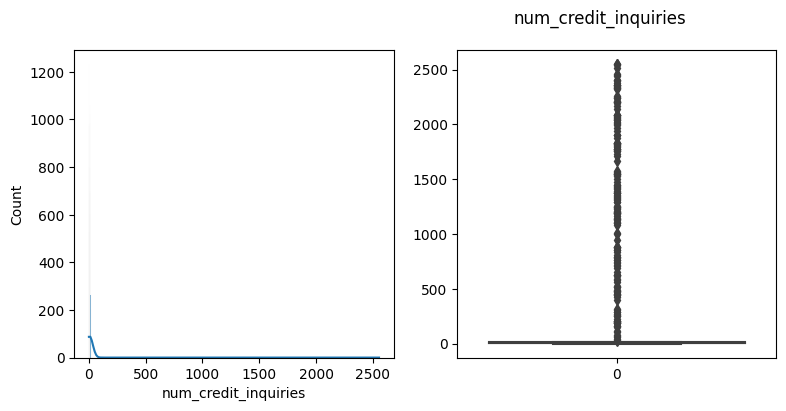

Skewness of outstanding_debt: 1.2076630068433065
Kurtosis of outstanding_debt: 0.9057206510751508


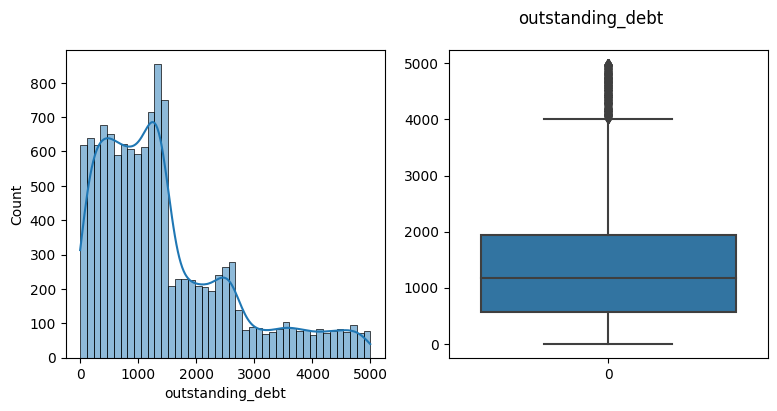

Skewness of credit_utilization_ratio: 0.0045664713156476164
Kurtosis of credit_utilization_ratio: -0.9688594177483956


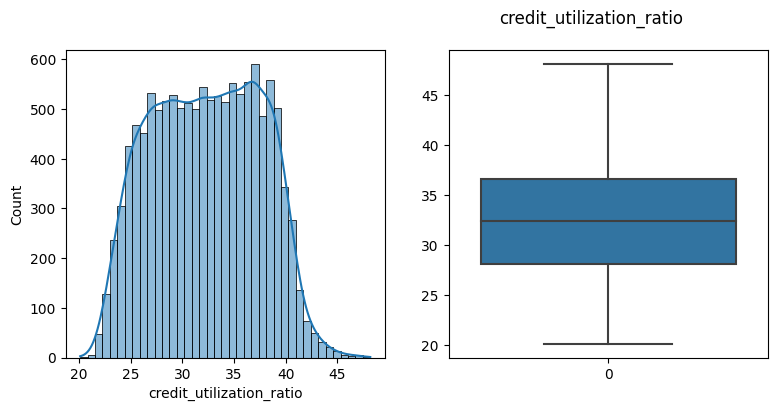

Skewness of credit_history_age: -0.050719229390694044
Kurtosis of credit_history_age: -0.8897923114338888


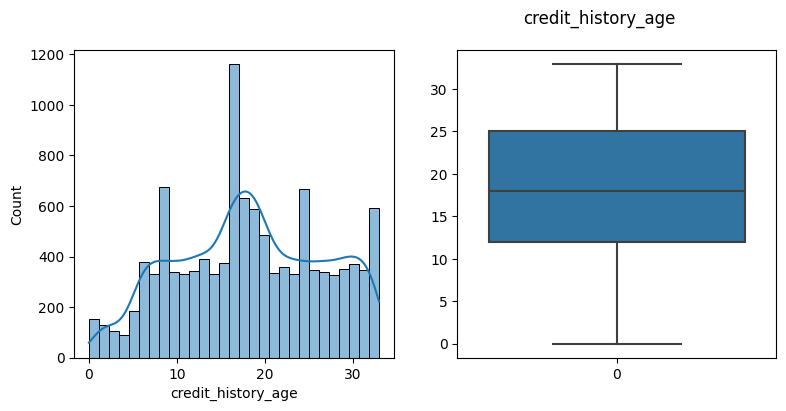

Skewness of total_emi_per_month: 6.928911456102072
Kurtosis of total_emi_per_month: 49.70881634843279


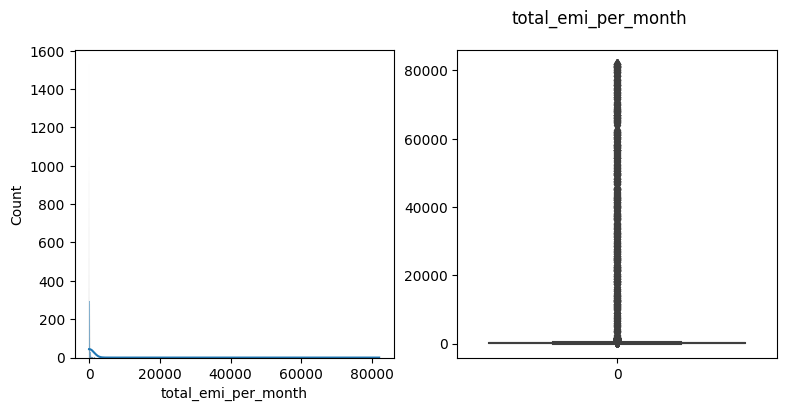

Skewness of amount_invested_monthly: 4.308685578786781
Kurtosis of amount_invested_monthly: 16.753756239307467


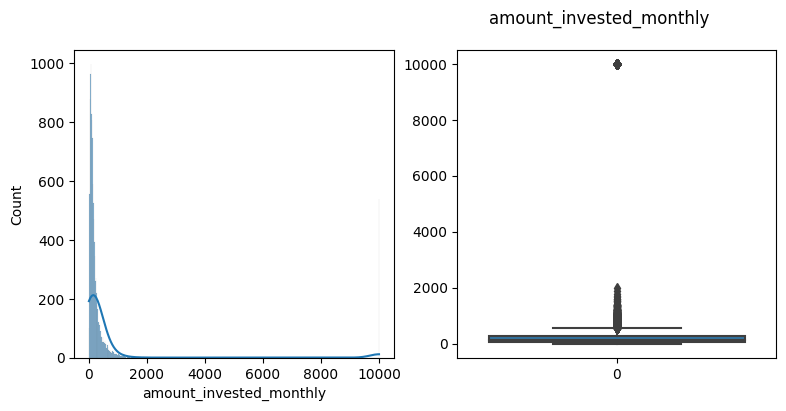

Skewness of credit_score: 0.9355823964205727
Kurtosis of credit_score: -1.124865583605668


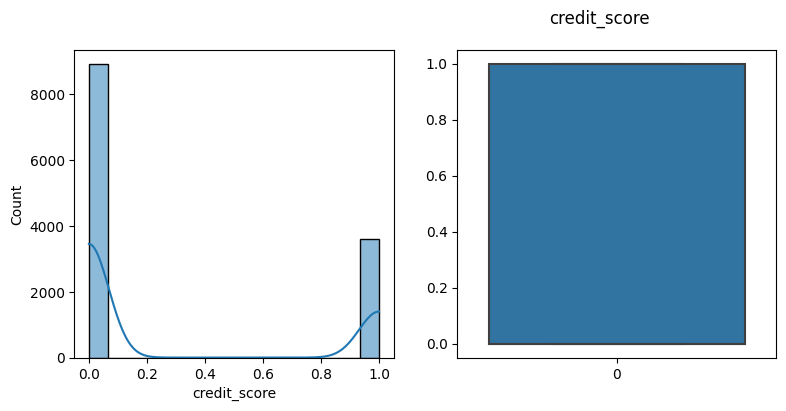

In [ ]:
#Distplot y gráfico de cajas para las variables numéricas.
#se elimina la columna 'monthly_balance' porque arroja error al graficar, ya que supera el límite.
for col in df.loc[:,df.columns!='monthly_balance'].select_dtypes(np.number).columns:
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurtosis())
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    #sns.displot(data=df[col], kde=True)
    sns.histplot(df[col], kde=True)
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.suptitle(col)
    plt.show();

# 3. Preparación de Datos

## Tratamiento de Datos nulos.

Podemos ver que para la variable numérica 'monthly_inhand_salary' existen 1916 registros nulos, sin embargo, se tiene la variable 'annual_income' que no posee registros nulos. Dado esto, podemos imputar en la variable 'monthly_inhad_salary' la suma estimada de dividir 'annual_income' en 12 meses obtiendo así un valor aproximado del ingreso mensual de la persona:

In [ ]:

columna_ingreso_mensual = 'monthly_inhand_salary'
columna_ingreso_anual = 'annual_income'

registros_nulos = df[columna_ingreso_mensual].isnull()

df.loc[registros_nulos, columna_ingreso_mensual] = df.loc[registros_nulos, columna_ingreso_anual] / 12



Se eliminan los registros que tengan valor nulo en la variable 'credit_history_age', 'num_of_delayed_payment', y 'monthly_balance' ya que se consideran variables claves
para conocer con certeza el comportamiento de una persona:

In [ ]:
df.dropna(subset=['credit_history_age'], inplace=True)
df.dropna(subset=['num_of_delayed_payment'], inplace=True)
df.dropna(subset=['monthly_balance'], inplace=True)

Se imputan ceros en los valores nulos de la columna 'amount_invested_monthly', ya que se considera que esta variable no guarda
una gran relación con la capacidad de pago de una persona:

In [ ]:
df['amount_invested_monthly'].fillna(0, inplace=True)

Se imputan ceros en los valores nulos de la columna 'num_credit_inquiries' y 'changed_credit_limit' porque si bien es cierto
aportan valor a la predicción del comportamiento de pago de una persona, no son variables determinantes y por dicha razón se dejan por defecto en 0 en vez de eliminar dichos registros.

In [ ]:
df['num_credit_inquiries'].fillna(0, inplace=True)
df['changed_credit_limit'].fillna(0, inplace=True)

## 3.1 Preprocesamiento con ColumnTransformer

In [ ]:
#En primer lugar convertimos el tipo de ciertas columnas.
df[['age','num_of_loan']] =  df[['age','num_of_loan']].astype('int64')
df['credit_score'] = df['credit_score'].astype('str')


In [ ]:
df.select_dtypes(['int64','float64'])

,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,total_emi_per_month,amount_invested_monthly,monthly_balance
0,23,19114.12,1824.843333,3,4,3,4,3,6.0,11.27,4.0,809.98,23.933795,NaN,49.574949,24.785217,358.124168
1,28,34847.84,3037.986667,2,4,6,1,3,4.0,5.42,2.0,605.03,32.933856,27.0,18.816215,218.904344,356.078109
2,34,143162.64,12187.220000,1,5,8,3,8,6.0,7.10,3.0,1303.01,38.374753,18.0,246.992319,10000.000000,895.494583
3,55,30689.89,2612.490833,2,5,4,-100,4,9.0,1.99,4.0,632.46,27.332515,17.0,16.415452,125.617251,379.216381
4,21,35547.71,2853.309167,7,5,5,-100,1,15.0,2.58,4.0,943.86,25.862922,31.0,0.000000,181.330901,364.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,19,42903.79,3468.315833,0,4,6,1,9,NaN,5.10,1.0,1079.48,35.716618,28.0,34.975457,115.184984,NaN
12496,45,16680.35,NaN,1,1,5,4,1,0.0,5.69,8.0,897.16,41.212367,NaN,41.113561,70.805550,NaN
12497,50,37188.10,3097.008333,1,4,5,3,7,9.0,5.38,3.0,620.64,39.300980,30.0,84.205949,42.935566,NaN
12498,29,20002.88,1929.906667,10,8,29,5,33,25.0,18.31,9.0,3571.70,37.140784,6.0,60.964772,34.662906,NaN


In [ ]:

# Columnas categóricas no ordinales a preprocesar
categorical_features = ['occupation','payment_of_min_amount','payment_behaviour']

# Columnas numéricas a escalar/estandarizar
numeric_features = ['age','num_bank_accounts','annual_income','monthly_inhand_salary',
                   'num_credit_card','interest_rate','num_of_loan','delay_from_due_date',
                   'num_of_delayed_payment','changed_credit_limit','num_credit_inquiries',
                   'outstanding_debt','credit_utilization_ratio','credit_history_age',
                   'total_emi_per_month','amount_invested_monthly','monthly_balance']

# Transformador para datos categóricos no ordinales
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False))
])

# Transformador para escalar/estandarizar datos numéricos
numeric_scaler = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# ColumnTransformer para combinar las transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features),
        ('numeric', numeric_scaler, numeric_features)
    ],
    remainder='drop'  # Mantener el resto de columnas no transformadas
)

# Setear el formato de salida a pandas
preprocessor.set_output(transform="pandas")

# Aplicar las transformaciones al DataFrame
df_transformed = preprocessor.fit_transform(df)

df_transformed = pd.DataFrame(df_transformed)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [ ]:
df_transformed.columns

Index(['categorical__occupation_Accountant',
       'categorical__occupation_Architect',
       'categorical__occupation_Developer', 'categorical__occupation_Doctor',
       'categorical__occupation_Engineer',
       'categorical__occupation_Entrepreneur',
       'categorical__occupation_Journalist', 'categorical__occupation_Lawyer',
       'categorical__occupation_Manager', 'categorical__occupation_Mechanic',
       'categorical__occupation_Media_Manager',
       'categorical__occupation_Musician', 'categorical__occupation_Scientist',
       'categorical__occupation_Teacher', 'categorical__occupation_Writer',
       'categorical__occupation________',
       'categorical__payment_of_min_amount_NM',
       'categorical__payment_of_min_amount_No',
       'categorical__payment_of_min_amount_Yes',
       'categorical__payment_behaviour_!@9#%8',
       'categorical__payment_behaviour_High_spent_Large_value_payments',
       'categorical__payment_behaviour_High_spent_Medium_value_payments',


In [ ]:
# A continuación una visualización de la dsitribución de las columnas numéricas estandarizadas

# Obtener las columnas que contienen la palabra 'scale' en su nombre
selected_columns = df_transformed.filter(like='scale').columns

# Eliminar el prefijo 'scale__' para obtener los nombres originales de las columnas
selected_columns_original = [col.replace('scale__', '') for col in selected_columns]

# Visualizar las distribuciones y boxplots para las columnas seleccionadas
for col_original, col_scaled in zip(selected_columns_original, selected_columns):
    plt.figure(figsize=(14, 4))
    plt.subplot(131)
    sns.histplot(df_transformed[col_scaled], kde=True)
    plt.title('Distribución')
    plt.subplot(132)
    sns.boxplot(df_transformed[col_scaled])
    plt.title('Boxplot')
    plt.suptitle(col_original, fontsize=16)
    plt.show()








## 3.2 Holdout

In [ ]:
df.columns

Index(['customer_id', 'age', 'occupation', 'annual_income',
       'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card',
       'interest_rate', 'num_of_loan', 'delay_from_due_date',
       'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
       'credit_history_age', 'payment_of_min_amount', 'total_emi_per_month',
       'amount_invested_monthly', 'payment_behaviour', 'monthly_balance',
       'credit_score'],
      dtype='object')

In [ ]:
target_column = 'credit_score'
df[target_column] = df[target_column].astype(int)
X = df.drop(columns=[target_column])
y = df[target_column]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




## 3.4 Feature Engineering

Agregamos 2 nuevas columnas al dataset:

Esta columna se llama 'balance_mensual_mas_inversion' y entrega el balance mensual en el caso de que se le sumara el dinero invertido por la persona al mes, de esta forma podriamos considerar un balance más alto que se traduciría en una mayor capacidad de pago, asumiendo que la inversión es liquidable en el corto plazo:

In [ ]:
df['balance_mensual_mas_inversion'] = df['monthly_balance'] + df['amount_invested_monthly']


Por otra parte se agrega también la columna 'porcentaje_del_sueldo_invertido' que entrega informacion del porcentaje del sueldo que
la persona invierte al mes, de esta forma podemos saber si la persona posee algun patrimonio que garantice el pago de algún prestamo que se
entregue a la persona en cuestión:

In [ ]:
df['porcentaje_del_sueldo_invertido'] = df['amount_invested_monthly'] / df['monthly_inhand_salary']

## 4. Baseline

Ponemos el pipeline y los modelos

In [ ]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = {
    'Dummy (Stratified)': DummyClassifier(strategy='stratified'),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier()
}

pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('model', model)]) for name, model in models.items()}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)

metrics = []
for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    metric_value = report['accuracy']
    metrics.append({'Model': name, 'Accuracy': metric_value})

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to 

In [ ]:
metrics_df = pd.DataFrame(metrics)

metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)

print(metrics_df)

                    Model  Accuracy
5           Random Forest  0.798254
6                LightGBM  0.796799
7                 XGBoost  0.776431
4  Support Vector Machine  0.758972
2     K-Nearest Neighbors  0.738603
1     Logistic Regression  0.737148
3           Decision Tree  0.695441
0      Dummy (Stratified)  0.590689


1. Si todos

2. El mejor es LightGBM

3. Bueno en realidad es mejor decir que los algoritmos basados en arboles son lo que tuvieron mejor rendimiento. Estos son una elección favorable en situaciones donde los datos contienen principalmente características categóricas. La capacidad intrínseca de los árboles de decisión para dividir y separar bien los datos en función de características categóricas los hace especialmente efectivos en este contexto.

4. El LightGBM, dado que solo una un arbol de desicion y varios como RandomForest.

## 5. Optimizacion del Modelo

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Modelo base a utilizar (LGBMClassifier)
model = LGBMClassifier()

# Pipeline completo con preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])


# Espacio de búsqueda de hiperparámetros para GridSearchCV
param_grid = {
    'preprocessor__numeric__scaler__with_mean': [True, False],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__n_estimators': [50, 100, 200]
}


# Instanciar GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Reportar el classification_report del mejor modelo en el conjunto de prueba
print("Classification Report del mejor modelo:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to 

Classification Report del mejor modelo:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1466
           1       0.69      0.53      0.60       596

    accuracy                           0.80      2062
   macro avg       0.76      0.72      0.73      2062
weighted avg       0.79      0.80      0.79      2062



In [ ]:
# Modelo base a utilizar (RandomForestClassifier)
model = RandomForestClassifier()

# Pipeline completo con preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])


# Espacio de búsqueda de hiperparámetros para GridSearchCV
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10],
    'model__min_samples_split': [2, 5],
}

# Instanciar GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=2)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Reportar el classification_report del mejor modelo en el conjunto de prueba
print("Classification Report del mejor modelo:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to 

Classification Report del mejor modelo:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1466
           1       0.70      0.53      0.60       596

    accuracy                           0.80      2062
   macro avg       0.77      0.72      0.73      2062
weighted avg       0.79      0.80      0.79      2062



## 6. Interpretabilidad

Para hacer la interpretabilidad, vamos a usar lo que es la importancia de características para sí tiene lógica que datos está usando para hacer este análisis.




In [ ]:
# Obtener la importancia de las características del modelo
feature_importances = best_model._final_estimator.feature_importances_

# Obtener los nombres de las características
sorted_indices = np.argsort(feature_importances)[::-1]

feat_labels = df_transformed.columns[1:]


for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            feature_importances[sorted_indices[f]]))

 1) numeric__credit_utilization_ratio 0.176328
 2) numeric__num_of_loan           0.121191
 3) numeric__num_of_delayed_payment 0.080297
 4) numeric__num_credit_inquiries  0.064493
 5) numeric__total_emi_per_month   0.063537
 6) numeric__outstanding_debt      0.058351
 7) numeric__annual_income         0.044550
 8) numeric__delay_from_due_date   0.041265
 9) numeric__interest_rate         0.037139
10) numeric__num_credit_card       0.036858
11) numeric__changed_credit_limit  0.035669
12) numeric__monthly_inhand_salary 0.035030
13) numeric__amount_invested_monthly 0.033367
14) numeric__credit_history_age    0.029663
15) numeric__monthly_balance       0.029289
16) numeric__num_bank_accounts     0.024074
17) categorical__payment_of_min_amount_Yes 0.016318
18) categorical__payment_behaviour_!@9#%8 0.010031
19) numeric__age                   0.006382
20) categorical__payment_behaviour_High_spent_Small_value_payments 0.004119
21) categorical__payment_behaviour_High_spent_Medium_value_payments

<ipython-input-35-db76a5b4d1e7>:6: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



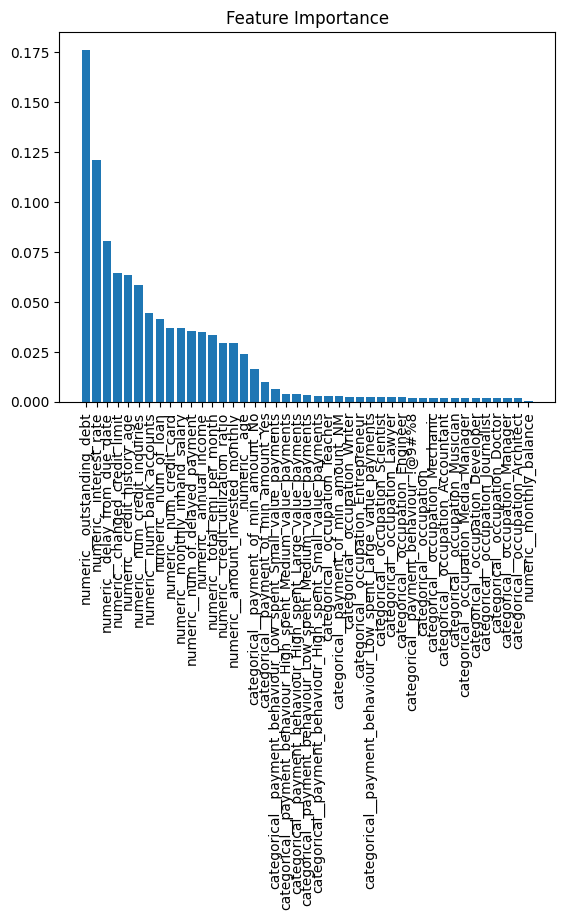

In [ ]:
import matplotlib.pyplot as plt

plt.title('Feature Importance')
plt.bar(range(df_transformed.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(df_transformed.shape[1]), df_transformed.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Podemos ver que la distribucion no es simetrica entre ellas.

Veamos la coherencia:

las variables mas importantes son

 1. numeric__credit_utilization_ratio: que esta tiene todo el sentido de ser la mas usada, dado que es que tanto credito usas y normalmente la gente que usa mayor credito tienden a ser clientes mas riesgosos.
 2. numeric__num_of_loan: Una persona que pide prestamos tambien es mas riesgoso            
 3. numeric__num_of_delayed_payment: entre mas dias se demora mas riesgoso.





In [ ]:
#Sacar las 10 columnas aleatorias

lista_columnas = df_transformed.columns.tolist()

# Utilizamos el método sample para seleccionar 10 columnas aleatorias
columnas_aleatorias = df.sample(n=10, axis=1)

print(columnas_aleatorias)

       num_credit_card  amount_invested_monthly  credit_utilization_ratio  \
1                    4               218.904344                 32.933856   
2                    5             10000.000000                 38.374753   
3                    5               125.617251                 27.332515   
4                    5               181.330901                 25.862922   
5                    5                42.635590                 31.580990   
...                ...                      ...                       ...   
12283                1               197.626771                 36.839608   
12284                7             10000.000000                 24.803887   
12285                6                30.430153                 28.746312   
12286                6               165.397552                 33.128609   
12287                4             10000.000000                 31.356267   

       num_of_loan  interest_rate  monthly_inhand_salary  \
1              

Entonces para este analisis, se van hacer correlaciones entre las variables, histogramas de cada variable y diagramas de dispersion

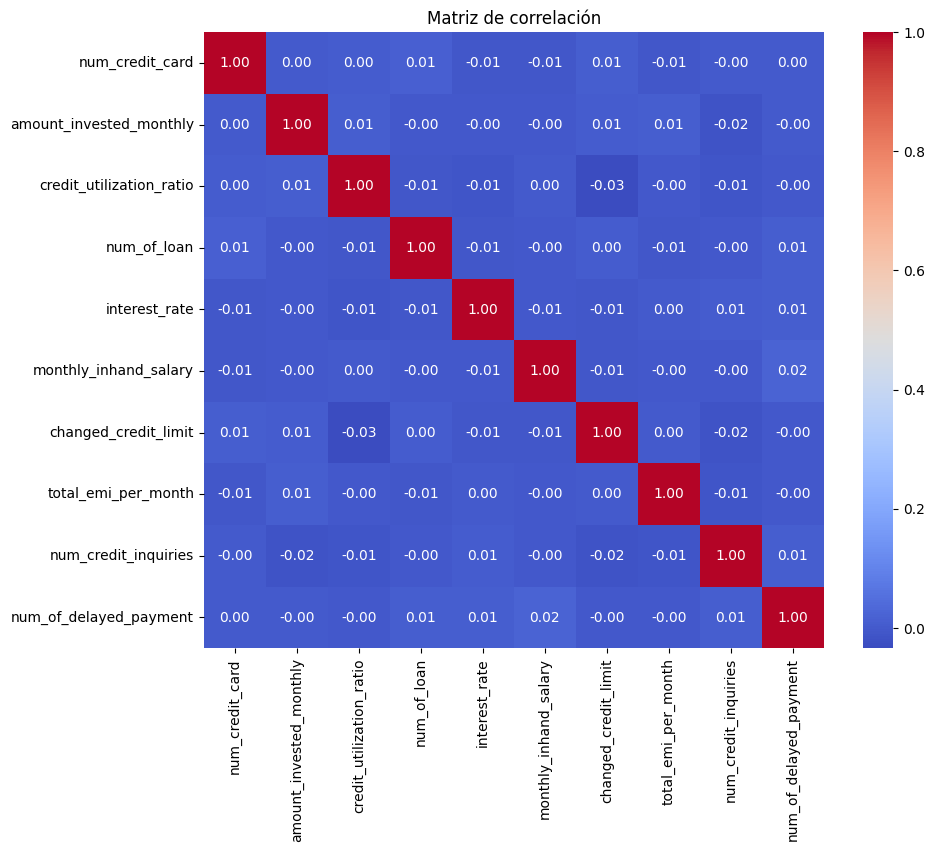

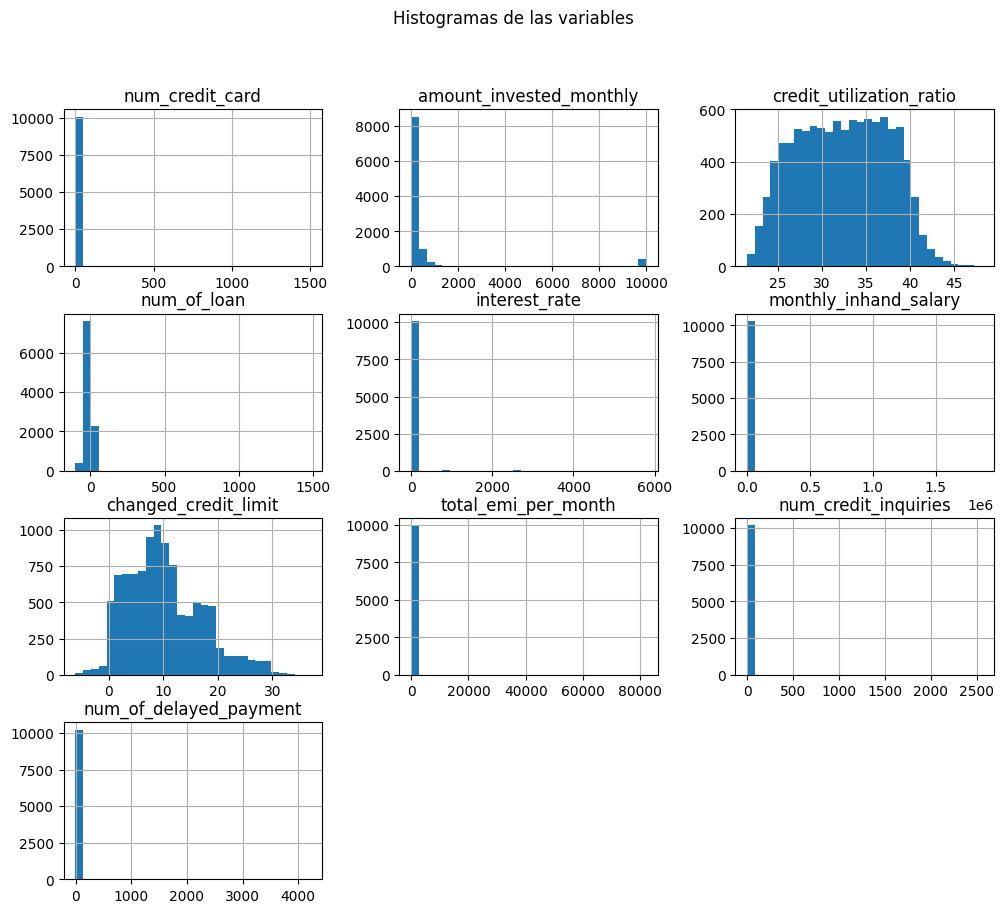

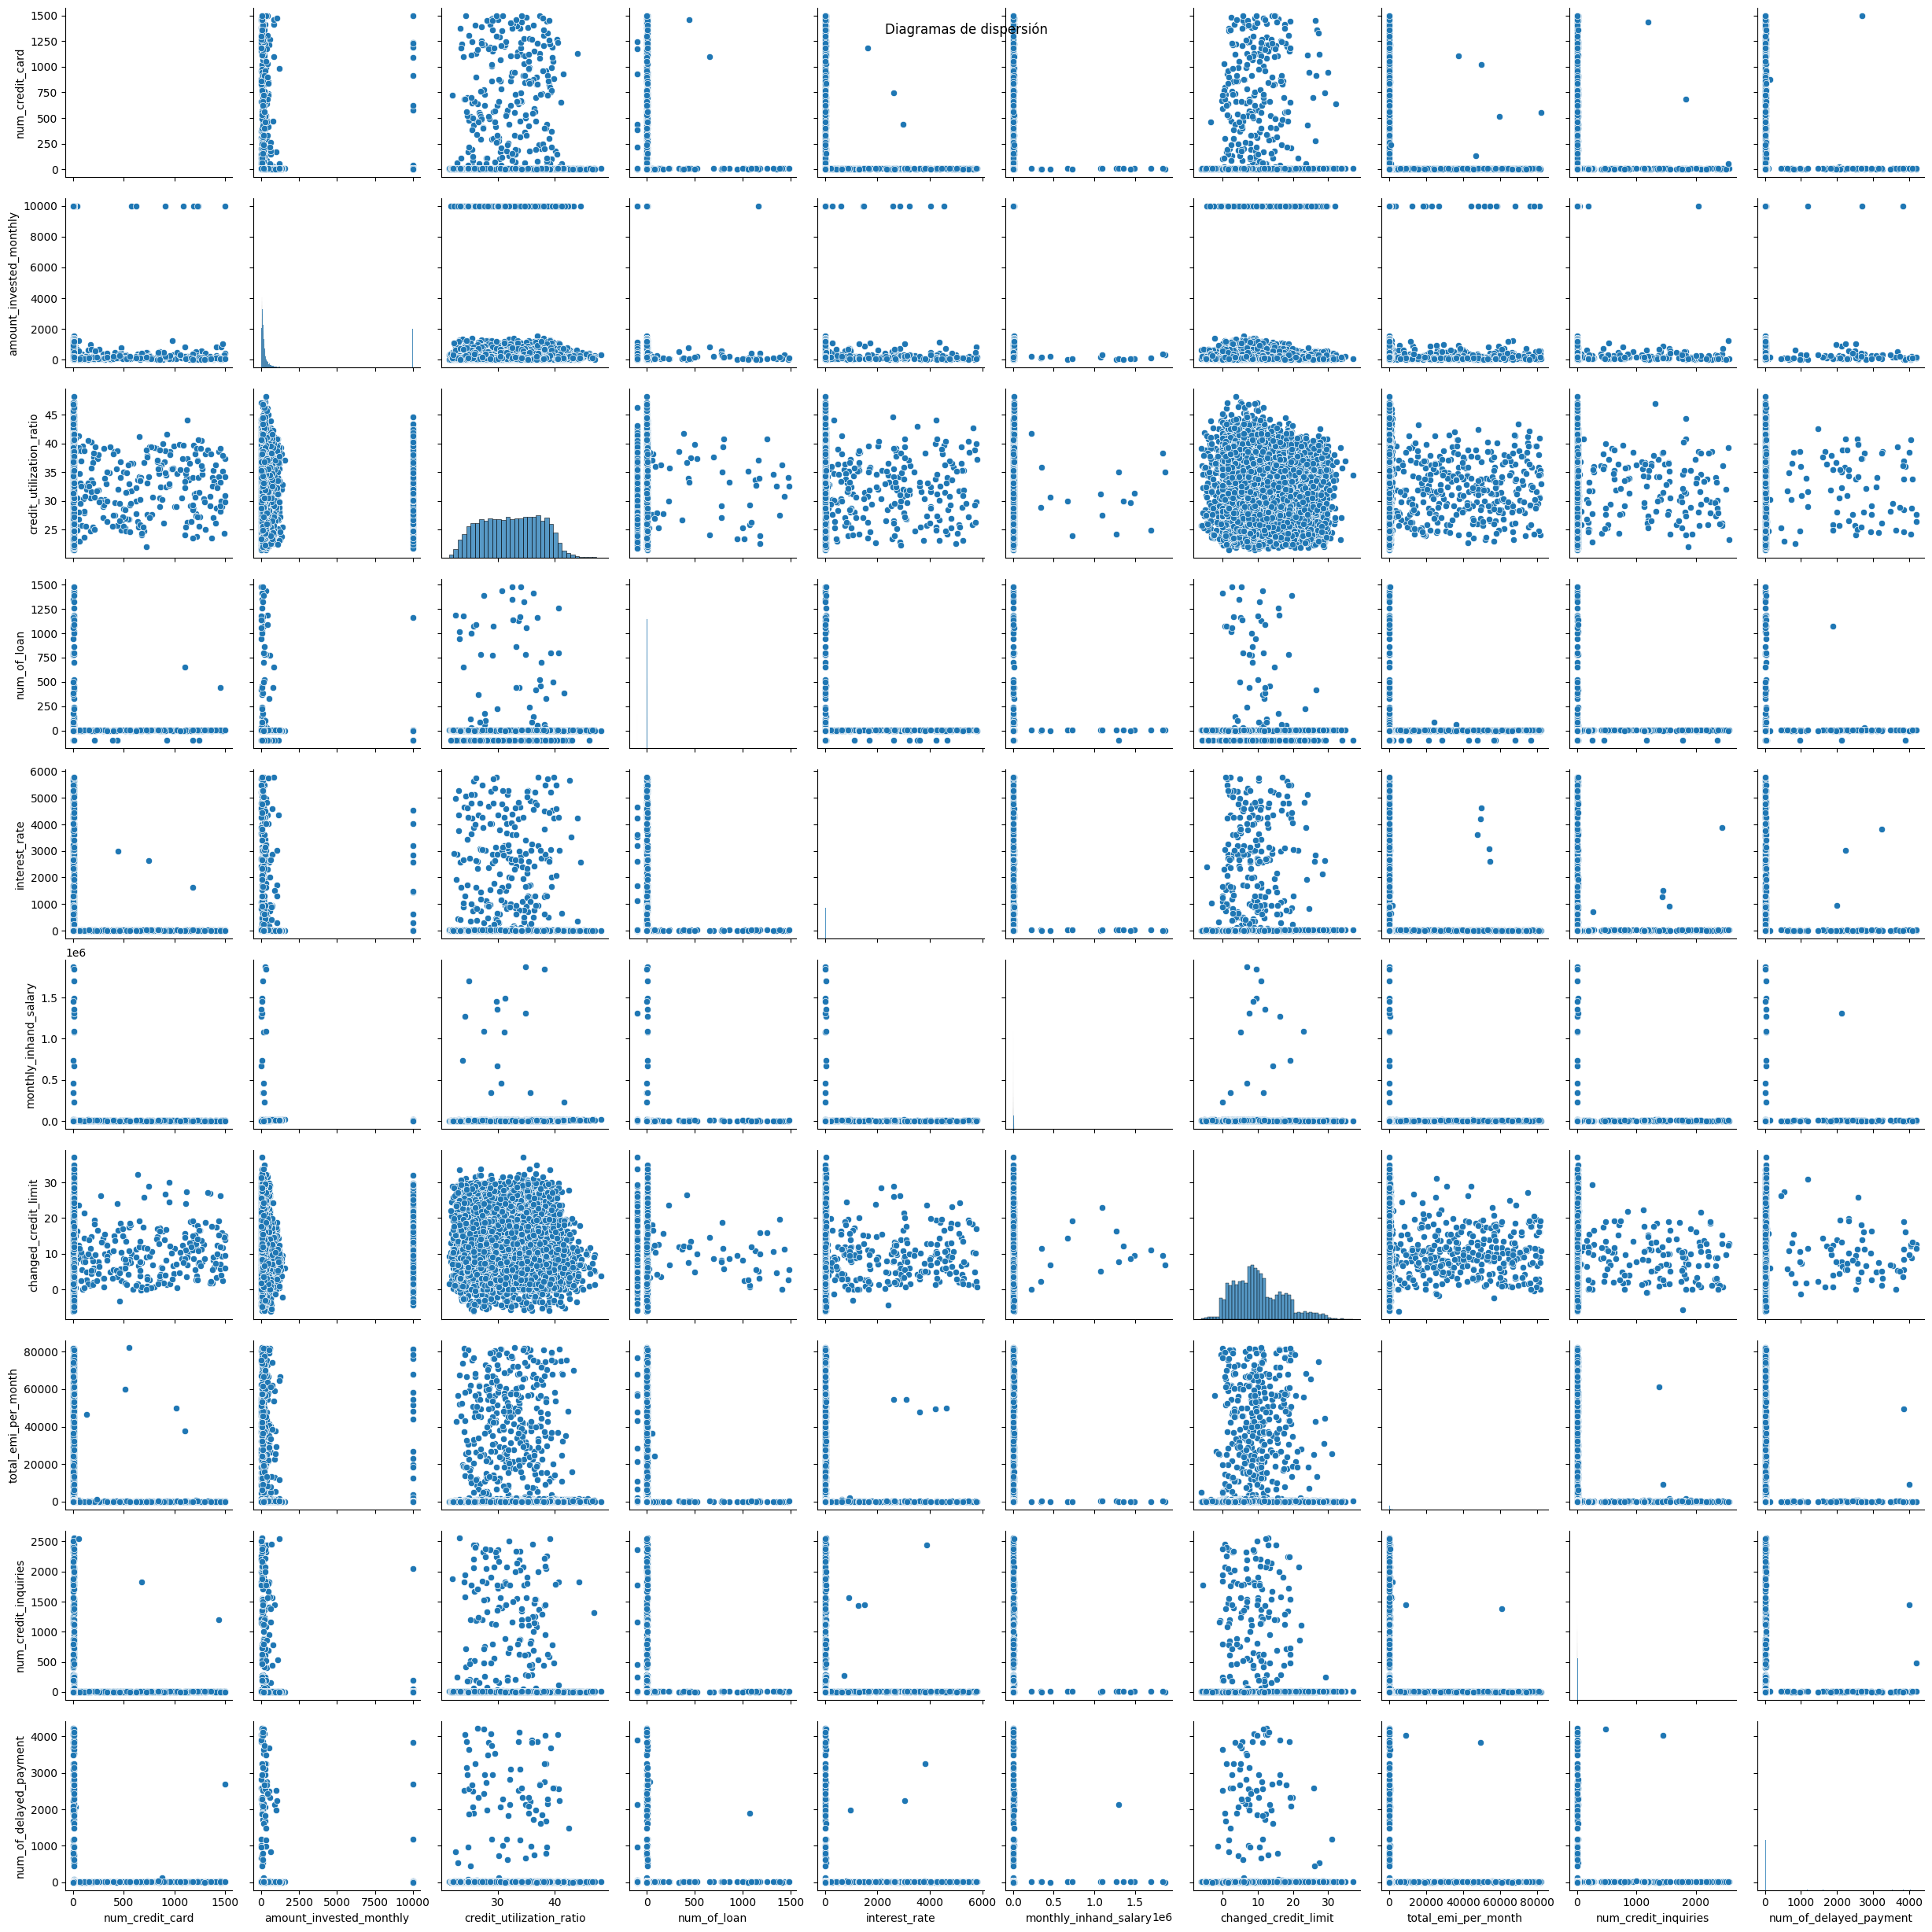

In [ ]:
import seaborn as sns

# Calcular la matriz de correlación entre las variables
correlation_matrix = columnas_aleatorias.corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

# Visualizar histogramas para cada variable
columnas_aleatorias.hist(figsize=(12, 10), bins=30)
plt.suptitle('Histogramas de las variables')
plt.show()

# Visualizar diagramas de dispersión entre pares de variables
sns.pairplot(columnas_aleatorias)
plt.suptitle('Diagramas de dispersión')
plt.show()

Correlación: Al realizar el análisis de correlación entre las variables, se observó que no existe una relación significativa entre ellas. Esto puede deberse a que las variables analizadas no son numéricas o no están linealmente relacionadas. Como resultado, no podemos establecer conexiones claras entre las características del conjunto de datos.

Histogramas: Durante el análisis de histogramas, se observó una presencia significativa de valores iguales a cero en varias variables. Esto sugiere que estas variables podrían no aportar mucha información útil para el problema en cuestión. Considerando esta información, sería recomendable evaluar si es apropiado eliminar dichas variables para simplificar el modelo y reducir la cantidad de ruido o información irrelevante.

Scatter-plots: Al visualizar los scatter-plots entre diferentes pares de variables, se confirmó que la mayoría de las variables no muestran una relación clara entre sí. Sin embargo, se identificó una alta varianza en la variable "amount_invested_monthly", lo que indica que esta variable puede ser importante y tener un impacto significativo en el problema modelado

7. Concluir

Concluimos que el problema pudo ser resuelto con éxito, obteniendo un nivel de precisión del 80%, lo cual es un resultado aceptable para nuestras necesidades. El análisis exploratorio de datos (EDA) fue fundamental en el proceso, ya que nos permitió identificar la importancia de ciertas características que se ajustaban bien al modelo. Sin embargo, no encontramos una relación clara entre algunas de las variables analizadas.

A pesar de intentar optimizar el modelo, no logramos mejoras significativas en el rendimiento. Creemos que un factor clave que pudo haber influido es el desequilibrio en los datos. Si hubiéramos logrado un equilibrio entre las clases, es probable que obtuviéramos mejores resultados.

Para futuras iteraciones, recomendamos eliminar las variables que contienen muchos valores constantes, ya que pueden no aportar información relevante. Además, es esencial trabajar en el equilibrio de las clases para mejorar la capacidad de predicción del modelo.

Esta experiencia nos enseñó la importancia de los datos en el proceso de modelado y cómo un EDA sólido puede brindar información valiosa sobre las características y la relación entre ellas. Concluimos que el éxito del modelo no solo depende del algoritmo utilizado, sino también de la calidad y relevancia de los datos que se utilizan en el proceso.

